# Part 1

Generate spikes for 10 s (or longer if you want better statistics) using a Poisson spike generator with a constant rate of 100 Hz, and record their times of occurrence. Compute the coefficient of variation of the interspike intervals, and the Fano factor for spike counts obtained over counting intervals ranging from 1 ms to 100 ms. Plot the interspike interval histogram.

The coefficient of variation of the inter-spike intervals is 0.973.
The Fano factors of the spike counts when the bin size is 1 ms is 0.906 and 0.958 for when it is 100 ms.


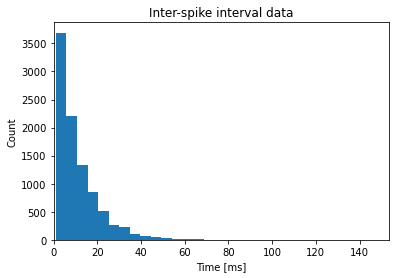

In [240]:
# Import the necessary packages
import matplotlib.pyplot as plt
import numpy as np

# For replicability
np.random.seed(101)

# Exercise 1_1
# Our goal is to generate and analyse spike times using a Poisson spike generator with a
# constant rate of 100 Hz. In other words, a homogeneous Poisson point process. We
# additionally need to obtain the inter-spike interval distribution and then calculate the
# Fano factor and the coefficient of variation

T = 100  # total time, seconds
r = 100  # firing rate, Hz
time_step = 0.001  # seconds
time_vector_max = int(T/time_step)
time_vector = np.arange(0, time_vector_max)
rt = time_step*r

# Generate the spikes using the native Poisson pdf function
spikes = np.random.poisson(lam=rt, size=time_vector_max)
spikes[spikes > 1] = 1

# Make a copy for later
spikes_org = spikes

# Obtain the spike times
spike_times = time_vector[spikes == 1]

# Generate the inter-spike interval data
t_isi = np.diff(spike_times)

# Plot the inter-spike interval data
plt.hist(t_isi, bins=30)
plt.xlim(left=0)
plt.title("Inter-spike interval data")
plt.xlabel("Time [ms]")
plt.ylabel("Count")

mean_t_isi = np.mean(t_isi)
std_t_isi = np.std(t_isi)
var_t_isi = std_t_isi**2
C_v = std_t_isi/mean_t_isi

# Calculate the Fano for 1 ms window
Fano_1ms = (np.std(spikes)**2)/np.mean(spikes)

k = 100

counts = []
for i in range(1, int(len(spikes)/k+1)):
    counts.append(sum(spikes[(i-1)*k:(i*k)]))

# Calculate the Fano for 100 ms window
Fano_100ms = np.var(counts)/np.mean(counts)


print(f"The coefficient of variation of the inter-spike intervals is {C_v:.3f}.")
print(f"The Fano factors of the spike counts when the bin size is 1 ms is {Fano_1ms:.3f} and "
      f"{Fano_100ms:.3f} for when it is 100 ms.")
plt.show()

# Part 2

Add a refractory period to the Poisson spike generator by allowing the firing rate to depend on time. Initially, set the firing rate to a constant value, $r(t)=r_0$. After every spike, set $r(t)$ to 0, and then allow it to recover exponentially back to $r_0$ with a time constant $\tau_{ref}$ that controls the refractory recovery rate. In other words, have $r(t)$ obey the equation

$$ 
\tau_{ref} \frac{dr}{dt} = r_0 - r 
$$

except immediately after a spike, when it is set to 0. Plot the coefficient of variation as a function of $\tau_{ref}$ over the range 1 ms $\leq \tau_{ref} \leq$ 20 ms, and plot interspike interval histograms for a few different values of $\tau_{ref}$ in this range. Compute the Fano factor for spike counts obtained
over counting intervals ranging from 1 to 100 ms for the case $\tau_{ref}$ = 10 ms. 

In [104]:
# Import the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

# For replicability
np.random.seed(101)

# Exercise 1_2
# Here, our task is to add a refractory period to the Poisson spike generator we created above. This 
# essentially turns the homogeneous Poisson point process into inhomogeneous since the rate is time-dependent. 
# In order to do that, we need to solve the differential equation given above. The section below explains how.

The solution to the differential equation in the continuous case is actually given in the book, see Mathematical Appendix A.3 Differential Equations, equation A.68. However, we need to discretise the solution for our present purposes. 

$$ 
\tau_{ref} \frac{dr}{dt} = r_0 - r(t)
$$

We need to integrate over the interval $[t, t + \Delta t ] $. Firstly, we use a placeholder variable $z(t)$ and set it to $z(t) = r(t) - r_0$ and we rewrite the equation as follows

$$
\frac{dz}{z} = -\frac{dt}{\tau_{ref}}
$$

Then we integrate both sides. 
LHS:

$$
\int_{z(t)}^{z(t+\Delta t)} dz' \frac{1}{z'} = ln(z(t + \Delta t)) - ln(z(t)) = ln \left( \frac{z(t + \Delta t)}{z(t)} \right)
$$

and RHS: 

$$
\int_{z(t)}^{z(t+\Delta t)} -\frac{dt}{\tau_{ref}} = -\frac{\Delta t}{\tau_{ref}}
$$

which yields, after taking the exponential of both sides
$$
\frac{z(t + \Delta t)}{z(t)} = exp \left ( -\frac{\Delta t}{\tau_{ref}} \right)
$$

$$
z(t + \Delta t) = z(t) \cdot exp \left ( -\frac{\Delta t}{\tau_{ref}} \right)
$$

Substituting back the $z$

$$
r(t + \Delta t) - r_0 = (r(t) - r_0 ) \cdot exp \left ( -\frac{\Delta t}{\tau_{ref}} \right)
$$

Thus, the solution is:

$$
r(t + \Delta t) = r_0 + (r(t) - r_0) \cdot exp \left ( -\frac{\Delta t}{\tau_{ref}} \right)
$$

(NB: Technically, we are making the assumption here that the $\Delta t$ is small enough that the firing rate doesn't change in this window.) 

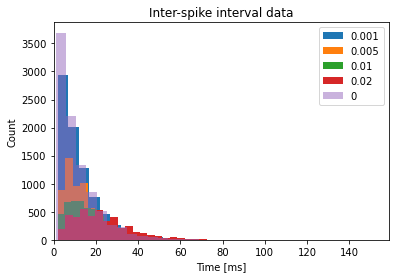

In [213]:
T = 100  # total time, seconds
r_0 = 100  # firing rate, Hz
time_step = 0.001  # seconds
time_vector_max = int(T/time_step)
time_vector = np.arange(0, time_vector_max)

# Generate the spikes using the native Poisson pdf function in a for loop this time 

def spike_generation(tau_r, spike_data):

    r = []
    spikes = []
    for count, value in enumerate(time_vector):

        # Set firing rate to the steady state value at first 
        if count == 0:
            r.append(r_0) 
            spikes.append(int(np.random.poisson(lam=r[count]*time_step, size=1)))

        else:  
            
            # Set firing rate to 0 immediately after a spike 
            if spikes[count-1] != 0: 
                r.append(0) 
                spikes.append(int(np.random.poisson(lam=r[count]*time_step, size=1)))
                
            else: 
                r.append(r_0 + (r[count-1] - r_0)*np.exp(-time_step/tau_r))
                spikes.append(int(np.random.poisson(lam=r[count]*time_step, size=1)))

    spikes = np.array(spikes)
    spikes[spikes > 1] = 1
    return spikes


# Create a list of taus 
tau_list = [0.001, 0.005, 0.01, 0.02]
spike_data = {}
isi_data = {}
Fano_1ms = []
Fano_100ms = []
C_v = []
k = 100

for tau_r in tau_list:

    spikes = spike_generation(tau_r, spike_data)
    spike_data[f"{tau_r}"] = spikes
    spike_times = time_vector[spike_data[f"{tau_r}"] == 1]
    isi_data[f"{tau_r}"] = np.diff(time_vector[spike_data[f"{tau_r}"] == 1])
    plt.hist(isi_data[f"{tau_r}"], bins=30)

    # Calculate the Fano for 1 ms window
    Fano_1ms.append((np.std(spikes)**2)/np.mean(spikes))

    # Compute the Fano factor for 100 ms window 
    counts = []
    for i in range(1, int(len(spikes)/k+1)):
        counts.append(sum(spikes[(i-1)*k:(i*k)]))

    Fano_100ms.append(np.var(counts)/np.mean(counts)) 
    
    # Compute the Cv for each isi 
    mean_t_isi = np.mean(isi_data[f"{tau_r}"])
    std_t_isi = np.std(isi_data[f"{tau_r}"])
    var_t_isi = std_t_isi**2
    C_v.append(std_t_isi/mean_t_isi)

    
# Plot the inter-spike interval data
# plt.figure()
plt.hist(t_isi, bins=30, alpha=0.5)
plt.xlim(left=0)
plt.title("Inter-spike interval data")
plt.xlabel("Time [ms]")
plt.ylabel("Count")
legend = []
[legend.append(val) for val in tau_list]
legend.append(0)
plt.legend(legend)
plt.show()    

# NB: The legend shows the values of tau for which the respective histogram was obtained. We also included the 
# histogram from the previous part for contrast

In [112]:
# Put together a simple table of our values 
df = pd.DataFrame()
df["Tau"] = tau_list
df["Cv"] = C_v
df["Fano 1ms"] = Fano_1ms
df["Fano 100ms"] = Fano_100ms
df

,Tau,Cv,Fano 1ms,Fano 100ms
0,0.001,0.831993,0.91888,0.690515
1,0.005,0.705965,0.93393,0.506213
2,0.010,0.647333,0.94613,0.423470
3,0.020,0.614008,0.95620,0.417260


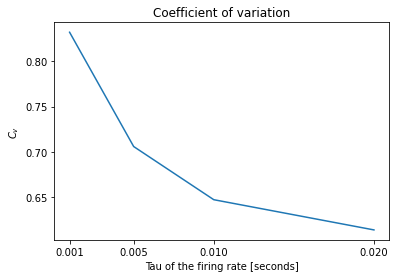

In [114]:
plt.figure()
plt.plot(tau_list, C_v)
plt.title("Coefficient of variation")
plt.xlabel("Tau of the firing rate [seconds]")
plt.ylabel("$C_v$")
plt.xticks(tau_list)
plt.show()

# Part 3

Compute autocorrelation histograms of spike trains generated by a Poisson generator with a constant firing rate of 100 Hz, a constant firing rate of 100 Hz together with a refractory period modeled as in exercise 2 with $\tau_{ref}$ = 10 ms, and a variable firing rate $r(t)$ = 100(1 + cos(2 $\pi t$/25 ms)) Hz. Plot the histograms over a range from 0 to 100 ms.

In [281]:
# We consider 3 cases: 
# 1. 100 Hz firing rate Poisson without a refractory period 
# 2. 100 Hz firing rate Poisson with a refractory period with tau of 10 ms
# 3. Harmonically varyng firing rate Poisson with a maximum of 100 Hz 

# 1. 100 Hz, no refractory period 
autocor_1 = np.correlate(spikes_org, spikes_org, mode='full')

# 2. 100 Hz, ref tau 0.01
autocor_2 = np.correlate(spike_data["0.01"], spike_data["0.01"], mode='full')

# 3. Variable firing rate 
harmonic_spikes = []
for t in time_vector:
    r = 100*(1+np.cos(2*np.pi*(t/1000)/0.025))
    harmonic_spikes.append(int(np.random.poisson(lam=r*time_step, size=1)))
harmonic_spikes = np.array(harmonic_spikes)
harmonic_spikes[harmonic_spikes > 1] = 1
autocor_3 = np.correlate(harmonic_spikes, harmonic_spikes, mode='full')

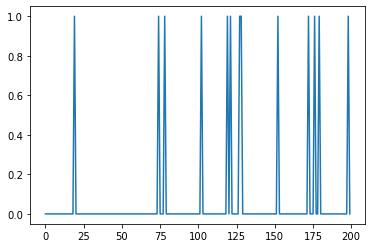

In [284]:
# Just to check that we coded everything correctly, the harmonic spikes should oscillate with high firing 
# rate values every 25ms. Ths is indeed what we see empirically when we plot the spikes
plt.plot(harmonic_spikes[0:200])

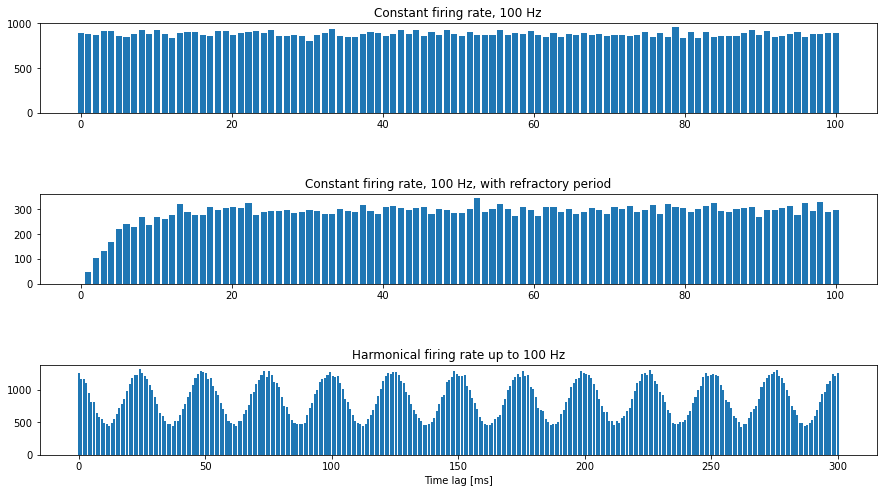

In [283]:
fig, axs = plt.subplots(3, figsize=(15,4))

# extract the autocorrelation values for positive lags
AotuCorr3 = autocor_3[int(np.ceil(autocor_3.size/2)):][0:300]
AotuCorr2 = autocor_2[int(np.ceil(autocor_2.size/2)):][0:100]
AotuCorr1 = autocor_1[int(np.ceil(autocor_1.size/2)):][0:100]
x = np.linspace(0, len(AotuCorr1), len(AotuCorr1))
x2 = np.linspace(0, len(AotuCorr3), len(AotuCorr3))

# Plot all three figures together 
axs[0].bar(x, AotuCorr1)
axs[0].set_title("Constant firing rate, 100 Hz")
axs[1].bar(x, AotuCorr2)
axs[1].set_title("Constant firing rate, 100 Hz, with refractory period")
axs[2].bar(x2, AotuCorr3)
axs[2].set_title("Harmonical firing rate up to 100 Hz")
axs[2].set_xlabel("Time lag [ms]")

plt.subplots_adjust(bottom=0.1,
                    top=1.6,
                    wspace=0.4,
                    hspace=0.9)

# Part 4

Generate a Poisson spike train with a time-dependent firing rate $r(t)=100(1+cos(2 \pi t $ / 300 ms)) Hz. Approximate the firing rate from this spike train using a variable $r_{approx}$ that satisfies

$$
\tau_{approx} \frac{d r_{approx}}{dt} = -r_{approx}
$$

except that $r_{approx} \longrightarrow r_{approx} + 1 /\tau_{approx} $ every time a spike occurs. Make plots of the true rate, the spike sequence generated, and the estimated rate. Experiment with a few different values of $\tau_{approx}$ the range of 1 to 100 ms. Determine the best value of $\tau_{approx}$ by computing the average squared error of the estimate, $\int dt (r(t) - r_{approx}(t))^2$, for different values of $\tau_{approx}$, and finding the value of $\tau_{approx}$ that minimizes this error.

Firstly, we need to solve the differential equation. We can do so as follows (ignoring any constants). 

$$
- \tau_{approx} \frac{d r_{approx}}{r_{approx}} = dt
$$

Integrating both parts

$$
-ln(r_{approx}) \tau_{approx} = t
$$


$$
ln(r_{approx})  = -\frac{t}{\tau_{approx}}
$$

$$
r_{approx}  = e^{(-\frac{t}{\tau_{approx}})}
$$

In [366]:
import pandas as pd 

# Approximate firing rate 
tau_approx_list = [0.01, 0.02, 0.05, 0.1]
    
# Poisson generated firing rate 
harmonic_spikes_2 = []
r_list = []

r_approx = pd.DataFrame({
    '0.01': [],
    '0.02': [],
    '0.05': [],
    '0.1': []
})

for count, t in enumerate(time_vector[0:5000]):
    r = 100*(1+np.cos(2*np.pi*(t/1000)/0.3))
    r_list.append(r)
    harmonic_spikes_2.append(int(np.random.poisson(lam=r*time_step, size=1)))

    # Loop through a list of taus 
    for tau_approx in tau_approx_list:
        
        if count == 0:
            r_approx.loc[count, str(tau_approx)] = r
        
        else:
            r_approx.loc[count, str(tau_approx)] = np.exp(-time_step/tau_approx)*r_approx.loc[count-1, str(tau_approx)]
    
        # If a spike was generated  
        if harmonic_spikes_2[-1] > 0: 
            r_approx.loc[count, str(tau_approx)] = r_approx.loc[count, str(tau_approx)] + 1/tau_approx


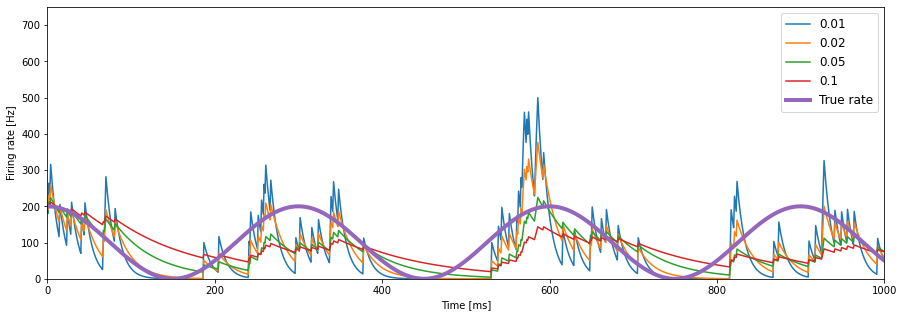

In [367]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(15, 5))

# Prep legend 
list1 = r_approx.columns
list2 = list1.to_list()
list2.append("True rate")

# Plot all the variables across time
plt.plot(r_approx[0:1000])
plt.plot(r_list[0:1000], linewidth=4)
ax.set_ylim([0, 750])
ax.set_xlim([0, 1000])
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Firing rate [Hz]")
plt.legend(list2, loc='upper right', fontsize=12)

In [371]:
# Determine the tau which best approximates the real firing rate by computing the the average 
# squared error of the estimate

square_error = pd.DataFrame({
    '0.01': [],
    '0.02': [],
    '0.05': [],
    '0.1': []
})

for count, r in enumerate(r_list): 
    for tau in tau_approx_list: 
        square_error.loc[count, str(tau)] = (r_approx.loc[count, str(tau)] - r)**2

In [380]:
print(f"The value of tau which best approxiamtes the real firing rate is {square_error.sum().idxmin()} ms")

The value of tau which best approxiamtes the real firing rate is 0.02 ms
